# Import Libraries

In [52]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor

# Obtain Data

Read csv with migration data into pandas

In [2]:
migration_df = pd.read_csv('Data/migration_data/migration_data.csv', header=1)
migration_df.head()

,id,Geographic Area Name,Estimate!!Total!!Population 1 year and over,Margin of Error!!Total!!Population 1 year and over,Estimate!!Total!!Population 1 year and over!!AGE!!1 to 4 years,Margin of Error!!Total!!Population 1 year and over!!AGE!!1 to 4 years,Estimate!!Total!!Population 1 year and over!!AGE!!5 to 17 years,Margin of Error!!Total!!Population 1 year and over!!AGE!!5 to 17 years,Estimate!!Total!!Population 1 year and over!!AGE!!18 to 24 years,Margin of Error!!Total!!Population 1 year and over!!AGE!!18 to 24 years,...,Estimate!!Moved; from abroad!!POVERTY STATUS IN THE PAST 12 MONTHS!!Population 1 year and over for whom poverty status is determined!!At or above 150 percent of the poverty level,Margin of Error!!Moved; from abroad!!POVERTY STATUS IN THE PAST 12 MONTHS!!Population 1 year and over for whom poverty status is determined!!At or above 150 percent of the poverty level,Estimate!!Moved; from abroad!!HOUSING TENURE!!Population 1 year and over in housing units,Margin of Error!!Moved; from abroad!!HOUSING TENURE!!Population 1 year and over in housing units,Estimate!!Moved; from abroad!!HOUSING TENURE!!Population 1 year and over in housing units!!Householder lived in owner-occupied housing units,Margin of Error!!Moved; from abroad!!HOUSING TENURE!!Population 1 year and over in housing units!!Householder lived in owner-occupied housing units,Estimate!!Moved; from abroad!!HOUSING TENURE!!Population 1 year and over in housing units!!Householder lived in renter-occupied housing units,Margin of Error!!Moved; from abroad!!HOUSING TENURE!!Population 1 year and over in housing units!!Householder lived in renter-occupied housing units,Estimate!!Moved; from abroad!!PERCENT ALLOCATED!!Residence 1 year ago,Margin of Error!!Moved; from abroad!!PERCENT ALLOCATED!!Residence 1 year ago
0,0500000US01003,"Baldwin County, Alabama",221737,907,9119,1103,36287,926,16614,1496,...,0.1,0.1,0.2,0.2,0.1,0.1,0.7,1.1,(X),(X)
1,0500000US01015,"Calhoun County, Alabama",112208,658,5302,657,17775,200,10047,750,...,0.0,0.2,0.0,0.2,0.0,0.2,0.0,0.5,(X),(X)
2,0500000US01043,"Cullman County, Alabama",83222,346,4764,706,13503,609,6160,397,...,0.0,0.3,0.0,0.2,0.0,0.3,0.0,0.9,(X),(X)
3,0500000US01049,"DeKalb County, Alabama",N,N,N,N,N,N,N,N,...,N,N,0.1,0.1,0.1,0.1,0.1,0.1,(X),(X)
4,0500000US01051,"Elmore County, Alabama",N,N,N,N,N,N,N,N,...,N,N,0.9,1.2,0.0,0.3,4.4,5.6,(X),(X)


Drop unneeded columns from migration_df, scrub formatting and combine interstate and intrastate migration columns into migration column

In [3]:
migration_df = migration_df[['Geographic Area Name',
                                'Estimate!!Moved; from different county, same state!!Population 1 year and over',
                                'Estimate!!Moved; from different  state!!Population 1 year and over']]
migration_df.replace({'N': np.nan}, inplace=True)
migration_df.columns = ['County', 'Intrastate Migration %', 'Interstate Migration %']
migration_df = migration_df.astype({'County': object, 'Intrastate Migration %': float,
                                    'Interstate Migration %': float})
migration_df['Inmigration %'] =  migration_df['Intrastate Migration %'] + migration_df['Interstate Migration %']
migration_df.head()

,County,Intrastate Migration %,Interstate Migration %,Inmigration %
0,"Baldwin County, Alabama",2.0,2.4,4.4
1,"Calhoun County, Alabama",2.7,4.1,6.8
2,"Cullman County, Alabama",3.5,0.9,4.4
3,"DeKalb County, Alabama",NaN,NaN,NaN
4,"Elmore County, Alabama",NaN,NaN,NaN


Read csv with economic data into pandas

In [4]:
economic_df = pd.read_csv('Data/economic_data/economic_data.csv', header=1)
economic_df.head()

,id,Geographic Area Name,Estimate!!EMPLOYMENT STATUS!!Population 16 years and over,Margin of Error!!EMPLOYMENT STATUS!!Population 16 years and over,Percent!!EMPLOYMENT STATUS!!Population 16 years and over,Percent Margin of Error!!EMPLOYMENT STATUS!!Population 16 years and over,Estimate!!EMPLOYMENT STATUS!!Population 16 years and over!!In labor force,Margin of Error!!EMPLOYMENT STATUS!!Population 16 years and over!!In labor force,Percent!!EMPLOYMENT STATUS!!Population 16 years and over!!In labor force,Percent Margin of Error!!EMPLOYMENT STATUS!!Population 16 years and over!!In labor force,...,Percent!!PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL!!All people!!18 years and over!!65 years and over,Percent Margin of Error!!PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL!!All people!!18 years and over!!65 years and over,Estimate!!PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL!!All people!!People in families,Margin of Error!!PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL!!All people!!People in families,Percent!!PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL!!All people!!People in families,Percent Margin of Error!!PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL!!All people!!People in families,Estimate!!PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL!!All people!!Unrelated individuals 15 years and over,Margin of Error!!PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL!!All people!!Unrelated individuals 15 years and over,Percent!!PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL!!All people!!Unrelated individuals 15 years and over,Percent Margin of Error!!PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL!!All people!!Unrelated individuals 15 years and over
0,0500000US01003,"Baldwin County, Alabama",183875,1197,183875,(X),101561,4760,55.2,2.6,...,9.1,3.1,(X),(X),8.3,2.5,(X),(X),18.5,4.1
1,0500000US01015,"Calhoun County, Alabama",92308,597,92308,(X),51001,2668,55.3,2.9,...,7.2,2.7,(X),(X),12.8,3.4,(X),(X),35.0,7.3
2,0500000US01043,"Cullman County, Alabama",66939,491,66939,(X),38222,1793,57.1,2.6,...,6.7,2.8,(X),(X),7.9,3.0,(X),(X),24.7,6.2
3,0500000US01049,"DeKalb County, Alabama",56471,671,56471,(X),34492,1971,61.1,3.4,...,8.5,3.6,(X),(X),17.9,5.5,(X),(X),28.6,5.9
4,0500000US01051,"Elmore County, Alabama",65674,847,65674,(X),37693,2523,57.4,3.9,...,5.1,3.1,(X),(X),10.5,4.0,(X),(X),18.2,7.0


Drop unneeded columns from economic_df, calculate unemployment rate and scrub formatting

In [5]:
economic_df = economic_df[['Geographic Area Name',
                           'Estimate!!EMPLOYMENT STATUS!!Population 16 years and over!!In labor force',
                           'Estimate!!EMPLOYMENT STATUS!!Population 16 years and over!!In labor force!!Civilian labor force!!Employed',
                           'Estimate!!INCOME AND BENEFITS (IN 2019 INFLATION-ADJUSTED DOLLARS)!!Per capita income (dollars)']]
economic_df.columns = ['County', 'Labor Force', 'Employment', 'Per Capita Income']
economic_df = economic_df.astype({'County': object, 'Labor Force': int, 'Employment': int, 
                                  'Per Capita Income': int})
economic_df['Unemployment Rate'] = economic_df['Labor Force'] - economic_df['Employment']
economic_df['Unemployment Rate'] = economic_df['Unemployment Rate'] / economic_df['Labor Force']
economic_df.head()

,County,Labor Force,Employment,Per Capita Income,Unemployment Rate
0,"Baldwin County, Alabama",101561,96012,32443,0.054637
1,"Calhoun County, Alabama",51001,45641,24579,0.105096
2,"Cullman County, Alabama",38222,36439,23968,0.046649
3,"DeKalb County, Alabama",34492,32544,21939,0.056477
4,"Elmore County, Alabama",37693,35358,31396,0.061948


Read csv with housing data into pandas

In [6]:
housing_df = pd.read_csv('Data/housing_data/housing_data.csv', header=1)
housing_df.head()

,id,Geographic Area Name,Estimate!!HOUSING OCCUPANCY!!Total housing units,Margin of Error!!HOUSING OCCUPANCY!!Total housing units,Percent!!HOUSING OCCUPANCY!!Total housing units,Percent Margin of Error!!HOUSING OCCUPANCY!!Total housing units,Estimate!!HOUSING OCCUPANCY!!Total housing units!!Occupied housing units,Margin of Error!!HOUSING OCCUPANCY!!Total housing units!!Occupied housing units,Percent!!HOUSING OCCUPANCY!!Total housing units!!Occupied housing units,Percent Margin of Error!!HOUSING OCCUPANCY!!Total housing units!!Occupied housing units,...,Percent!!GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME (GRAPI)!!Occupied units paying rent (excluding units where GRAPI cannot be computed)!!30.0 to 34.9 percent,Percent Margin of Error!!GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME (GRAPI)!!Occupied units paying rent (excluding units where GRAPI cannot be computed)!!30.0 to 34.9 percent,Estimate!!GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME (GRAPI)!!Occupied units paying rent (excluding units where GRAPI cannot be computed)!!35.0 percent or more,Margin of Error!!GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME (GRAPI)!!Occupied units paying rent (excluding units where GRAPI cannot be computed)!!35.0 percent or more,Percent!!GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME (GRAPI)!!Occupied units paying rent (excluding units where GRAPI cannot be computed)!!35.0 percent or more,Percent Margin of Error!!GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME (GRAPI)!!Occupied units paying rent (excluding units where GRAPI cannot be computed)!!35.0 percent or more,Estimate!!GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME (GRAPI)!!Occupied units paying rent (excluding units where GRAPI cannot be computed)!!Not computed,Margin of Error!!GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME (GRAPI)!!Occupied units paying rent (excluding units where GRAPI cannot be computed)!!Not computed,Percent!!GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME (GRAPI)!!Occupied units paying rent (excluding units where GRAPI cannot be computed)!!Not computed,Percent Margin of Error!!GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME (GRAPI)!!Occupied units paying rent (excluding units where GRAPI cannot be computed)!!Not computed
0,0500000US01003,"Baldwin County, Alabama",119425,483,119425,(X),82325,3231,68.9,2.7,...,8.2,4.5,6003,1790,41.7,10.0,2648,1235,(X),(X)
1,0500000US01015,"Calhoun County, Alabama",53809,404,53809,(X),44636,2010,83.0,3.7,...,8.4,5.2,4659,1199,38.6,8.6,1074,642,(X),(X)
2,0500000US01043,"Cullman County, Alabama",38256,332,38256,(X),32090,1233,83.9,3.2,...,8.0,5.7,1839,569,25.5,7.6,575,279,(X),(X)
3,0500000US01049,"DeKalb County, Alabama",31606,256,31606,(X),24880,1347,78.7,4.1,...,22.6,10.7,1292,711,22.7,10.4,1392,635,(X),(X)
4,0500000US01051,"Elmore County, Alabama",34481,471,34481,(X),30712,1330,89.1,3.4,...,4.3,3.6,3726,1274,54.1,11.8,968,629,(X),(X)


Drop unneeded columns from housing_df and scrub formatting

In [7]:
housing_df = housing_df[['Geographic Area Name', 'Estimate!!VALUE!!Owner-occupied units!!Median (dollars)']]
housing_df.columns = ['County', 'Median House Price']
housing_df = housing_df.astype({'County': object, 'Median House Price': int})
housing_df.head()

,County,Median House Price
0,"Baldwin County, Alabama",223100
1,"Calhoun County, Alabama",121600
2,"Cullman County, Alabama",137600
3,"DeKalb County, Alabama",115200
4,"Elmore County, Alabama",176100


Read csv with education data into pandas

In [8]:
education_df = pd.read_csv('Data/education_data/education_data.csv', header=1)
education_df.head()

,id,Geographic Area Name,Estimate!!Total!!AGE BY EDUCATIONAL ATTAINMENT!!Population 18 to 24 years,Margin of Error!!Total!!AGE BY EDUCATIONAL ATTAINMENT!!Population 18 to 24 years,Estimate!!Total!!AGE BY EDUCATIONAL ATTAINMENT!!Population 18 to 24 years!!Less than high school graduate,Margin of Error!!Total!!AGE BY EDUCATIONAL ATTAINMENT!!Population 18 to 24 years!!Less than high school graduate,Estimate!!Total!!AGE BY EDUCATIONAL ATTAINMENT!!Population 18 to 24 years!!High school graduate (includes equivalency),Margin of Error!!Total!!AGE BY EDUCATIONAL ATTAINMENT!!Population 18 to 24 years!!High school graduate (includes equivalency),Estimate!!Total!!AGE BY EDUCATIONAL ATTAINMENT!!Population 18 to 24 years!!Some college or associate's degree,Margin of Error!!Total!!AGE BY EDUCATIONAL ATTAINMENT!!Population 18 to 24 years!!Some college or associate's degree,...,Estimate!!Percent Female!!MEDIAN EARNINGS IN THE PAST 12 MONTHS (IN 2019 INFLATION-ADJUSTED DOLLARS)!!Population 25 years and over with earnings!!Less than high school graduate,Margin of Error!!Percent Female!!MEDIAN EARNINGS IN THE PAST 12 MONTHS (IN 2019 INFLATION-ADJUSTED DOLLARS)!!Population 25 years and over with earnings!!Less than high school graduate,Estimate!!Percent Female!!MEDIAN EARNINGS IN THE PAST 12 MONTHS (IN 2019 INFLATION-ADJUSTED DOLLARS)!!Population 25 years and over with earnings!!High school graduate (includes equivalency),Margin of Error!!Percent Female!!MEDIAN EARNINGS IN THE PAST 12 MONTHS (IN 2019 INFLATION-ADJUSTED DOLLARS)!!Population 25 years and over with earnings!!High school graduate (includes equivalency),Estimate!!Percent Female!!MEDIAN EARNINGS IN THE PAST 12 MONTHS (IN 2019 INFLATION-ADJUSTED DOLLARS)!!Population 25 years and over with earnings!!Some college or associate's degree,Margin of Error!!Percent Female!!MEDIAN EARNINGS IN THE PAST 12 MONTHS (IN 2019 INFLATION-ADJUSTED DOLLARS)!!Population 25 years and over with earnings!!Some college or associate's degree,Estimate!!Percent Female!!MEDIAN EARNINGS IN THE PAST 12 MONTHS (IN 2019 INFLATION-ADJUSTED DOLLARS)!!Population 25 years and over with earnings!!Bachelor's degree,Margin of Error!!Percent Female!!MEDIAN EARNINGS IN THE PAST 12 MONTHS (IN 2019 INFLATION-ADJUSTED DOLLARS)!!Population 25 years and over with earnings!!Bachelor's degree,Estimate!!Percent Female!!MEDIAN EARNINGS IN THE PAST 12 MONTHS (IN 2019 INFLATION-ADJUSTED DOLLARS)!!Population 25 years and over with earnings!!Graduate or professional degree,Margin of Error!!Percent Female!!MEDIAN EARNINGS IN THE PAST 12 MONTHS (IN 2019 INFLATION-ADJUSTED DOLLARS)!!Population 25 years and over with earnings!!Graduate or professional degree
0,0500000US01003,"Baldwin County, Alabama",16614,1496,2316,1329,7398,2126,5354,1439,...,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X)
1,0500000US01015,"Calhoun County, Alabama",10047,750,897,568,2099,981,6507,842,...,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X)
2,0500000US01043,"Cullman County, Alabama",6160,397,731,375,1871,552,3111,624,...,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X)
3,0500000US01049,"DeKalb County, Alabama",7072,650,1240,731,2441,788,3122,953,...,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X)
4,0500000US01051,"Elmore County, Alabama",5605,681,1053,549,1928,765,2179,567,...,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X)


Drop unneeded columns from education_df, calculate bachleros degree proportion and scrub formatting

In [9]:
education_df = education_df[['Geographic Area Name', 
                             'Estimate!!Total!!AGE BY EDUCATIONAL ATTAINMENT!!Population 25 years and over',
                             "Estimate!!Total!!AGE BY EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Bachelor's degree"]]
education_df.columns = ['County', 'Population 25+', 'Bachelors Degree 25+']
education_df = education_df.astype({'County': object, 'Population 25+': int, 'Bachelors Degree 25+': int})
education_df['Bachelors Degree %'] = education_df['Bachelors Degree 25+']/education_df['Population 25+']
education_df.head()

,County,Population 25+,Bachelors Degree 25+,Bachelors Degree %
0,"Baldwin County, Alabama",159717,32781,0.205244
1,"Calhoun County, Alabama",79084,9082,0.114840
2,"Cullman County, Alabama",58795,5935,0.100944
3,"DeKalb County, Alabama",47007,3693,0.078563
4,"Elmore County, Alabama",57553,9418,0.163640


Read csv with commute data into pandas

In [10]:
commute_df = pd.read_csv('Data/commute_data/commute_data.csv', header=1)
commute_df.head()

,id,Geographic Area Name,Estimate!!Total!!Workers 16 years and over,Margin of Error!!Total!!Workers 16 years and over,"Estimate!!Total!!Workers 16 years and over!!MEANS OF TRANSPORTATION TO WORK!!Car, truck, or van","Margin of Error!!Total!!Workers 16 years and over!!MEANS OF TRANSPORTATION TO WORK!!Car, truck, or van","Estimate!!Total!!Workers 16 years and over!!MEANS OF TRANSPORTATION TO WORK!!Car, truck, or van!!Drove alone","Margin of Error!!Total!!Workers 16 years and over!!MEANS OF TRANSPORTATION TO WORK!!Car, truck, or van!!Drove alone","Estimate!!Total!!Workers 16 years and over!!MEANS OF TRANSPORTATION TO WORK!!Car, truck, or van!!Carpooled","Margin of Error!!Total!!Workers 16 years and over!!MEANS OF TRANSPORTATION TO WORK!!Car, truck, or van!!Carpooled",...,Estimate!!Female!!PERCENT ALLOCATED!!Private vehicle occupancy,Margin of Error!!Female!!PERCENT ALLOCATED!!Private vehicle occupancy,Estimate!!Female!!PERCENT ALLOCATED!!Place of work,Margin of Error!!Female!!PERCENT ALLOCATED!!Place of work,Estimate!!Female!!PERCENT ALLOCATED!!Time of departure to go to work,Margin of Error!!Female!!PERCENT ALLOCATED!!Time of departure to go to work,Estimate!!Female!!PERCENT ALLOCATED!!Travel time to work,Margin of Error!!Female!!PERCENT ALLOCATED!!Travel time to work,Estimate!!Female!!PERCENT ALLOCATED!!Vehicles available,Margin of Error!!Female!!PERCENT ALLOCATED!!Vehicles available
0,0500000US01003,"Baldwin County, Alabama",94867,4720,94.3,1.6,85.6,2.5,8.7,2.0,...,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X)
1,0500000US01015,"Calhoun County, Alabama",N,N,N,N,N,N,N,N,...,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X)
2,0500000US01043,"Cullman County, Alabama",35840,1743,96.5,1.6,83.6,4.0,12.9,3.9,...,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X)
3,0500000US01049,"DeKalb County, Alabama",N,N,N,N,N,N,N,N,...,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X)
4,0500000US01051,"Elmore County, Alabama",N,N,N,N,N,N,N,N,...,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X)


Drop unneeded columns from commute_df and scrub data

In [11]:
commute_df = commute_df[['Geographic Area Name', 
                         'Estimate!!Total!!Workers 16 years and over who did not work from home!!TRAVEL TIME TO WORK!!Mean travel time to work (minutes)']]
commute_df.columns = ['County', 'Commute Time']
commute_df = commute_df.astype({'County': object, 'Commute Time': float})
commute_df.head()

,County,Commute Time
0,"Baldwin County, Alabama",26.1
1,"Calhoun County, Alabama",22.3
2,"Cullman County, Alabama",27.9
3,"DeKalb County, Alabama",24.9
4,"Elmore County, Alabama",26.5


Read csv with weather data into pandas

In [12]:
weather_df = pd.read_csv('Data/weather_data/weather_data.csv', header=3)
weather_df.head()

,Location ID,Location,Value,Rank,Anomaly (1901-2000 base period),1901-2000 Mean
0,AL-001,Autauga County,65.4,114,1.5,63.9
1,AL-003,Baldwin County,67.4,92,0.6,66.8
2,AL-005,Barbour County,65.3,86,0.5,64.8
3,AL-007,Bibb County,63.3,83,0.6,62.7
4,AL-009,Blount County,62.0,109,1.4,60.6


Drop unneeded columns from weather_df and scrub formatting

In [13]:
weather_df = weather_df[['Location ID', 'Location', '1901-2000 Mean']]
weather_df.head()
weather_df.columns = ['State', 'County', 'Mean Temperature']
weather_df.head()

,State,County,Mean Temperature
0,AL-001,Autauga County,63.9
1,AL-003,Baldwin County,66.8
2,AL-005,Barbour County,64.8
3,AL-007,Bibb County,62.7
4,AL-009,Blount County,60.6


Reformat county names to match other tables

In [14]:
state_abbreviations_df = pd.read_csv('Data/weather_data/state_abbreviations.csv')
state_abbreviations_df.head()

def state_column(row):
    abbreviation = row.split('-')[0]
    return state_abbreviations_df[state_abbreviations_df['Abbreviation']==abbreviation]['State'].values[0]
weather_df['State'] = weather_df['State'].apply(state_column)
weather_df['County'] = weather_df['County'] + ', ' + weather_df['State']
weather_df.drop(columns='State', inplace=True)
weather_df.head()

,County,Mean Temperature
0,"Autauga County, Alabama",63.9
1,"Baldwin County, Alabama",66.8
2,"Barbour County, Alabama",64.8
3,"Bibb County, Alabama",62.7
4,"Blount County, Alabama",60.6


Merge data from dfs with census data into a single df

In [15]:
df_list = [migration_df, economic_df, housing_df, education_df, commute_df]
df = migration_df['County']
for data_df in df_list:
    df = pd.merge(df, data_df, how='inner', on='County')
print(df.shape)
df.head()

(840, 13)


,County,Intrastate Migration %,Interstate Migration %,Inmigration %,Labor Force,Employment,Per Capita Income,Unemployment Rate,Median House Price,Population 25+,Bachelors Degree 25+,Bachelors Degree %,Commute Time
0,"Baldwin County, Alabama",2.0,2.4,4.4,101561,96012,32443,0.054637,223100,159717,32781,0.205244,26.1
1,"Calhoun County, Alabama",2.7,4.1,6.8,51001,45641,24579,0.105096,121600,79084,9082,0.114840,22.3
2,"Cullman County, Alabama",3.5,0.9,4.4,38222,36439,23968,0.046649,137600,58795,5935,0.100944,27.9
3,"DeKalb County, Alabama",NaN,NaN,NaN,34492,32544,21939,0.056477,115200,47007,3693,0.078563,24.9
4,"Elmore County, Alabama",NaN,NaN,NaN,37693,35358,31396,0.061948,176100,57553,9418,0.163640,26.5


Reformat df county names to match weather_df county names and merge the two dfs

In [16]:
df['County'] = df['County'].apply(lambda x: x.replace('city,', 'City,'))
df['County'] = df['County'].apply(lambda x: x.replace('ñ', 'n'))
weather_df['County'] = weather_df['County'].apply(lambda x: x.replace('Washington, D.C., Maryland',
                                                                      'District of Columbia, District of Columbia'))

df = pd.merge(df, weather_df, how='outer', on='County')
print(df.shape)
df.head()

(3151, 14)


,County,Intrastate Migration %,Interstate Migration %,Inmigration %,Labor Force,Employment,Per Capita Income,Unemployment Rate,Median House Price,Population 25+,Bachelors Degree 25+,Bachelors Degree %,Commute Time,Mean Temperature
0,"Baldwin County, Alabama",2.0,2.4,4.4,101561.0,96012.0,32443.0,0.054637,223100.0,159717.0,32781.0,0.205244,26.1,66.8
1,"Calhoun County, Alabama",2.7,4.1,6.8,51001.0,45641.0,24579.0,0.105096,121600.0,79084.0,9082.0,0.114840,22.3,60.9
2,"Cullman County, Alabama",3.5,0.9,4.4,38222.0,36439.0,23968.0,0.046649,137600.0,58795.0,5935.0,0.100944,27.9,60.3
3,"DeKalb County, Alabama",NaN,NaN,NaN,34492.0,32544.0,21939.0,0.056477,115200.0,47007.0,3693.0,0.078563,24.9,59.3
4,"Elmore County, Alabama",NaN,NaN,NaN,37693.0,35358.0,31396.0,0.061948,176100.0,57553.0,9418.0,0.163640,26.5,63.8


# Scrub data

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3151 entries, 0 to 3150
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   County                  3151 non-null   object 
 1   Intrastate Migration %  671 non-null    float64
 2   Interstate Migration %  671 non-null    float64
 3   Inmigration %           671 non-null    float64
 4   Labor Force             840 non-null    float64
 5   Employment              840 non-null    float64
 6   Per Capita Income       840 non-null    float64
 7   Unemployment Rate       840 non-null    float64
 8   Median House Price      840 non-null    float64
 9   Population 25+          840 non-null    float64
 10  Bachelors Degree 25+    840 non-null    float64
 11  Bachelors Degree %      840 non-null    float64
 12  Commute Time            840 non-null    float64
 13  Mean Temperature        3136 non-null   float64
dtypes: float64(13), object(1)
memory usage: 

Drop all counties with no census data from df

In [18]:
df.dropna(thresh=9, inplace=True)
print(df.shape)
df.head()

(840, 14)


,County,Intrastate Migration %,Interstate Migration %,Inmigration %,Labor Force,Employment,Per Capita Income,Unemployment Rate,Median House Price,Population 25+,Bachelors Degree 25+,Bachelors Degree %,Commute Time,Mean Temperature
0,"Baldwin County, Alabama",2.0,2.4,4.4,101561.0,96012.0,32443.0,0.054637,223100.0,159717.0,32781.0,0.205244,26.1,66.8
1,"Calhoun County, Alabama",2.7,4.1,6.8,51001.0,45641.0,24579.0,0.105096,121600.0,79084.0,9082.0,0.114840,22.3,60.9
2,"Cullman County, Alabama",3.5,0.9,4.4,38222.0,36439.0,23968.0,0.046649,137600.0,58795.0,5935.0,0.100944,27.9,60.3
3,"DeKalb County, Alabama",NaN,NaN,NaN,34492.0,32544.0,21939.0,0.056477,115200.0,47007.0,3693.0,0.078563,24.9,59.3
4,"Elmore County, Alabama",NaN,NaN,NaN,37693.0,35358.0,31396.0,0.061948,176100.0,57553.0,9418.0,0.163640,26.5,63.8


Drop datapoints from Puerto Rico from df

In [19]:
def drop_pr(row):
    if 'Puerto Rico' in row:
        return 'Puerto Rico'
    else:
        return row

df['County'] = df['County'].apply(drop_pr)
df = df[df['County'] != 'Puerto Rico']
print(df.shape)
df.head()

(829, 14)


,County,Intrastate Migration %,Interstate Migration %,Inmigration %,Labor Force,Employment,Per Capita Income,Unemployment Rate,Median House Price,Population 25+,Bachelors Degree 25+,Bachelors Degree %,Commute Time,Mean Temperature
0,"Baldwin County, Alabama",2.0,2.4,4.4,101561.0,96012.0,32443.0,0.054637,223100.0,159717.0,32781.0,0.205244,26.1,66.8
1,"Calhoun County, Alabama",2.7,4.1,6.8,51001.0,45641.0,24579.0,0.105096,121600.0,79084.0,9082.0,0.114840,22.3,60.9
2,"Cullman County, Alabama",3.5,0.9,4.4,38222.0,36439.0,23968.0,0.046649,137600.0,58795.0,5935.0,0.100944,27.9,60.3
3,"DeKalb County, Alabama",NaN,NaN,NaN,34492.0,32544.0,21939.0,0.056477,115200.0,47007.0,3693.0,0.078563,24.9,59.3
4,"Elmore County, Alabama",NaN,NaN,NaN,37693.0,35358.0,31396.0,0.061948,176100.0,57553.0,9418.0,0.163640,26.5,63.8


Fill missing mean tempurature for all Hawaii counties with researched mean of 77.7

In [20]:
def fill_hawaii(row):
    if 'Hawaii' in row['County']:
        row['Mean Temperature'] = 77.7
        return row
    else:
        return row
    
df = df.apply(fill_hawaii, axis=1)
df.head()

,County,Intrastate Migration %,Interstate Migration %,Inmigration %,Labor Force,Employment,Per Capita Income,Unemployment Rate,Median House Price,Population 25+,Bachelors Degree 25+,Bachelors Degree %,Commute Time,Mean Temperature
0,"Baldwin County, Alabama",2.0,2.4,4.4,101561.0,96012.0,32443.0,0.054637,223100.0,159717.0,32781.0,0.205244,26.1,66.8
1,"Calhoun County, Alabama",2.7,4.1,6.8,51001.0,45641.0,24579.0,0.105096,121600.0,79084.0,9082.0,0.114840,22.3,60.9
2,"Cullman County, Alabama",3.5,0.9,4.4,38222.0,36439.0,23968.0,0.046649,137600.0,58795.0,5935.0,0.100944,27.9,60.3
3,"DeKalb County, Alabama",NaN,NaN,NaN,34492.0,32544.0,21939.0,0.056477,115200.0,47007.0,3693.0,0.078563,24.9,59.3
4,"Elmore County, Alabama",NaN,NaN,NaN,37693.0,35358.0,31396.0,0.061948,176100.0,57553.0,9418.0,0.163640,26.5,63.8


Drop County column and other features not useful for modeling

In [21]:
drop_features = ['County', 'Intrastate Migration %', 'Interstate Migration %', 'Labor Force', 'Employment', 
                 'Population 25+', 'Bachelors Degree 25+']
df.drop(columns=drop_features, inplace=True)
df.head()

,Inmigration %,Per Capita Income,Unemployment Rate,Median House Price,Bachelors Degree %,Commute Time,Mean Temperature
0,4.4,32443.0,0.054637,223100.0,0.205244,26.1,66.8
1,6.8,24579.0,0.105096,121600.0,0.114840,22.3,60.9
2,4.4,23968.0,0.046649,137600.0,0.100944,27.9,60.3
3,NaN,21939.0,0.056477,115200.0,0.078563,24.9,59.3
4,NaN,31396.0,0.061948,176100.0,0.163640,26.5,63.8


Drop rows missing the Inmigration % dependent variable

In [22]:
df = df[df['Inmigration %'].notna()]
print(df.shape)
df.head()

(671, 7)


,Inmigration %,Per Capita Income,Unemployment Rate,Median House Price,Bachelors Degree %,Commute Time,Mean Temperature
0,4.4,32443.0,0.054637,223100.0,0.205244,26.1,66.8
1,6.8,24579.0,0.105096,121600.0,0.114840,22.3,60.9
2,4.4,23968.0,0.046649,137600.0,0.100944,27.9,60.3
6,4.0,27762.0,0.068778,155600.0,0.142307,22.2,66.5
7,4.7,32561.0,0.049472,170000.0,0.203708,25.7,61.8


Confirm dataset is now scrubbed with df.info()

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 671 entries, 0 to 828
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Inmigration %       671 non-null    float64
 1   Per Capita Income   671 non-null    float64
 2   Unemployment Rate   671 non-null    float64
 3   Median House Price  671 non-null    float64
 4   Bachelors Degree %  671 non-null    float64
 5   Commute Time        671 non-null    float64
 6   Mean Temperature    671 non-null    float64
dtypes: float64(7)
memory usage: 41.9 KB


# Explore Data

Use Isolation Forest to find outliers and confirm no miscollected datapoints an extreme number of standard deviations from mean 

In [24]:
isf_df = df.drop(columns=['Inmigration %'])
ss = StandardScaler()

ss_isf_df = pd.DataFrame(ss.fit_transform(isf_df), columns=isf_df.columns)
isf = IsolationForest(random_state=47)
ss_isf_df['Outlier'] = isf.fit_predict(ss_isf_df)
ss_isf_df[(ss_isf_df['Outlier']==-1) & (ss_isf_df.ge(5).sum(axis=1).values)]

,Per Capita Income,Unemployment Rate,Median House Price,Bachelors Degree %,Commute Time,Mean Temperature,Outlier
46,4.757764,-0.405496,5.651523,2.775644,1.543147,0.053569,-1
56,4.747072,-0.492955,6.598591,2.564005,1.776362,0.172947,-1
59,4.026275,-0.738008,6.708524,1.494801,0.843505,0.125196,-1
61,3.238743,-0.543453,6.037315,1.370023,0.882374,0.304263,-1
218,-1.202474,8.162665,-0.834560,-0.773550,-2.071674,0.352014,-1
364,-1.602878,5.030573,-0.901476,-1.936673,-0.516912,0.256512,-1
376,-0.937418,6.404111,-0.686388,-1.105406,-1.061079,-1.283465,-1
407,-1.098731,5.014095,-0.781300,-0.712984,-0.730692,0.817588,-1
421,-1.207291,8.233849,-0.586014,-0.418355,-0.905602,0.865340,-1
565,-1.340172,5.903472,-0.805881,-1.447824,-0.652954,1.318976,-1


Calculate variable descriptive statistics with df.describe()

In [25]:
df.describe()

,Inmigration %,Per Capita Income,Unemployment Rate,Median House Price,Bachelors Degree %,Commute Time,Mean Temperature
count,671.000000,671.000000,671.000000,6.710000e+02,671.000000,671.000000,671.000000
mean,6.525037,34679.743666,0.055365,2.511230e+05,0.199641,25.559762,54.351267
std,2.488187,8517.754682,0.036244,1.465613e+05,0.058929,5.149322,8.383000
min,1.500000,17542.000000,0.010353,7.360000e+04,0.070558,14.900000,26.500000
25%,4.800000,29099.000000,0.036793,1.630000e+05,0.153173,21.850000,47.750000
50%,6.100000,32928.000000,0.046414,2.123000e+05,0.196237,24.800000,53.000000
75%,7.800000,38171.000000,0.060402,2.911500e+05,0.235958,28.450000,60.300000
max,17.500000,82720.000000,0.353569,1.233600e+06,0.389095,47.100000,77.700000


Plot distribution of df variables

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your c

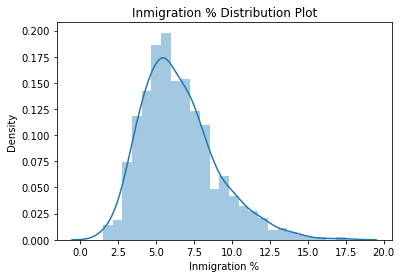

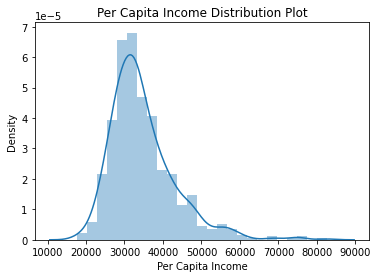

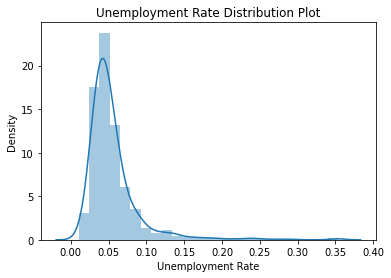

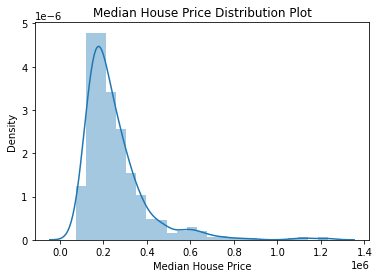

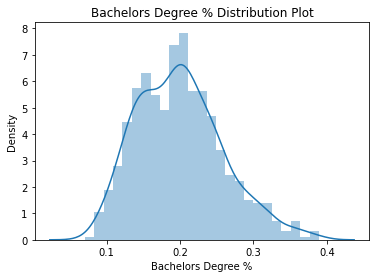

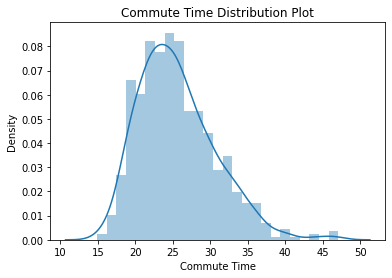

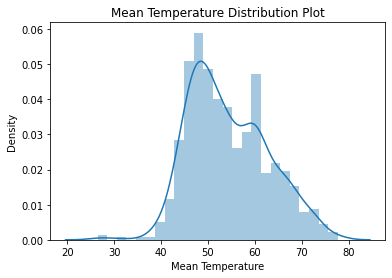

In [26]:
for feat in df.columns:
    fig, ax = plt.subplots()
    sns.distplot(df[feat], kde=True, bins=25, ax=ax)
    ax.set_title(f'{feat} Distribution Plot')

Plot relationship between each feature and the dependent variable

Text(0.5, 0.98, 'County Migration Dataset Pairplot')

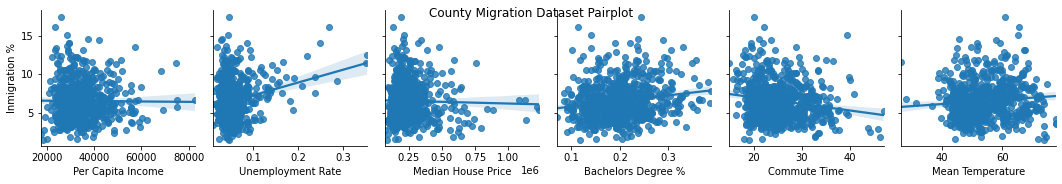

In [27]:
x_vars = list(df.columns)
x_vars.remove('Inmigration %')
pairplot = sns.pairplot(df, x_vars = x_vars, y_vars=['Inmigration %'], kind='reg')
pairplot.fig.suptitle('County Migration Dataset Pairplot')

Calculate VIF to confirm that no correlated features need to be removed

In [28]:
vif_df = add_constant(df.drop(columns='Inmigration %'))
vif_output = []
for num in range(0, len(vif_df.columns)):
    vif_output.append([vif_df.columns[num], variance_inflation_factor(vif_df.values, num)])
pd.DataFrame(vif_output, columns=['Column', 'VIF'])

,Column,VIF
0,const,96.106580
1,Per Capita Income,4.718923
2,Unemployment Rate,1.151811
3,Median House Price,2.559068
4,Bachelors Degree %,2.832208
5,Commute Time,1.416851
6,Mean Temperature,1.153785


# Model Data

Create x and y variables from df

In [29]:
x = df.drop(columns=['Inmigration %'])
y = df['Inmigration %']

Split x and y variables into train and test groups

In [30]:
x_train, x_test, y_train, y_test = train_test_split(x,y,random_state=12)

Standard scale x variables

In [31]:
ss = StandardScaler()
ss.fit(x_train)
x_train = pd.DataFrame(ss.transform(x_train), columns=x.columns)
x_test = pd.DataFrame(ss.transform(x_test), columns=x.columns)

Build and validate dummy regressor model

In [32]:
dr = DummyRegressor()
dr.fit(x_train, y_train)
y_train_pred_dr = dr.predict(x_train) 
y_test_pred_dr = dr.predict(x_test)
print('Dummy Regressor Evaluation:')
print('Train RMSE', np.sqrt(mean_squared_error(y_train, y_train_pred_dr)))
print('Train MAE', mean_absolute_error(y_train, y_train_pred_dr))
print('Train r2', r2_score(y_train, y_train_pred_dr))
print('Test RMSE', np.sqrt(mean_squared_error(y_test, y_test_pred_dr)))
print('Test MAE', mean_absolute_error(y_test, y_test_pred_dr))
print('Test r2', r2_score(y_test, y_test_pred_dr))

Dummy Regressor Evaluation:
Train RMSE 2.4881364699810273
Train MAE 1.9283732989735543
Train r2 0.0
Test RMSE 2.4828629135090425
Test MAE 2.020097273501846
Test r2 -0.006282302574558196


Build and validate linear regression model

In [33]:
lr = LinearRegression()
lr.fit(x_train, y_train)
y_train_pred_lr = lr.predict(x_train) 
y_test_pred_lr = lr.predict(x_test)
print('Linear Regression Evaluation:')
print('Train RMSE', np.sqrt(mean_squared_error(y_train, y_train_pred_lr)))
print('Train MAE', mean_absolute_error(y_train, y_train_pred_lr))
print('Train r2', r2_score(y_train, y_train_pred_lr))
print('Test RMSE', np.sqrt(mean_squared_error(y_test, y_test_pred_lr)))
print('Test MAE', mean_absolute_error(y_test, y_test_pred_lr))
print('Test r2', r2_score(y_test, y_test_pred_lr))

Linear Regression Evaluation:
Train RMSE 2.2721726786687975
Train MAE 1.7502573840693803
Train r2 0.16606102227047648
Test RMSE 2.1525705453076305
Test MAE 1.6959650986021853
Test r2 0.2436389805948389


Gridsearch elastic net model

In [34]:
en_dict = {'alpha': [x * 0.01 for x in range(0, 501)], 'l1_ratio': [x * 0.01 for x in range(0, 101)]}
en_model = ElasticNet()
en = GridSearchCV(en_model, en_dict, cv=5, n_jobs=-1, 
                     scoring='neg_root_mean_squared_error', verbose=1) 
en.fit(x_train, y_train)
print('Elastic Net Gridsearch')
print('Best Params', en.best_params_)
print('Best Score', en.best_score_)

Fitting 5 folds for each of 50601 candidates, totalling 253005 fits
Elastic Net Gridsearch
Best Params {'alpha': 0.06, 'l1_ratio': 0.0}
Best Score -2.323795191865558


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1326.3613419148014, tolerance: 0.3113984015904573
  model = cd_fast.enet_coordinate_descent(


Build and validate top performing elastic net model

In [35]:
en = ElasticNet(alpha=0.06, l1_ratio=0.0)
en.fit(x_train, y_train)
y_train_pred_en = en.predict(x_train) 
y_test_pred_en = en.predict(x_test)
print('Linear Regression Evaluation:')
print('Train RMSE', np.sqrt(mean_squared_error(y_train, y_train_pred_en)))
print('Train MAE', mean_absolute_error(y_train, y_train_pred_en))
print('Train r2', r2_score(y_train, y_train_pred_en))
print('Test RMSE', np.sqrt(mean_squared_error(y_test, y_test_pred_en)))
print('Test MAE', mean_absolute_error(y_test, y_test_pred_en))
print('Test r2', r2_score(y_test, y_test_pred_en))

Linear Regression Evaluation:
Train RMSE 2.27599050114238
Train MAE 1.7469866790630137
Train r2 0.16325621274194402
Test RMSE 2.165288523034472
Test MAE 1.709836579526469
Test r2 0.23467500067243718


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1326.3613419148014, tolerance: 0.3113984015904573
  model = cd_fast.enet_coordinate_descent(


# Evaluate Results

Create df with linear regression coefficients

In [36]:
coef_df = pd.DataFrame(lr.coef_, columns=['Coefficient'])
coef_df['Feature'] = x.columns
coef_df.sort_values(by='Coefficient', inplace=True)
coef_df

,Coefficient,Feature
0,-0.469393,Per Capita Income
4,-0.346617,Commute Time
2,-0.065405,Median House Price
5,0.256506,Mean Temperature
1,0.658104,Unemployment Rate
3,1.175954,Bachelors Degree %


Plot linear regression coefficients

[Text(0, 0, 'Per Capita Income'),
 Text(1, 0, 'Commute Time'),
 Text(2, 0, 'Median House Price'),
 Text(3, 0, 'Mean Temperature'),
 Text(4, 0, 'Unemployment Rate'),
 Text(5, 0, 'Bachelors Degree %')]

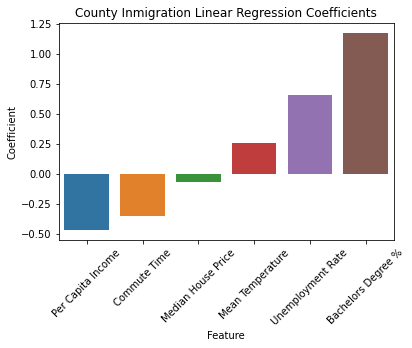

In [37]:
fig, ax = plt.subplots()
sns.barplot(x='Feature', y='Coefficient', data=coef_df, ax=ax)
ax.set_title('County Inmigration Linear Regression Coefficients')
ax.set_xticklabels(coef_df['Feature'], rotation=45)

# Non-Linear Modeling

Gridsearch knn regressor model

In [50]:
knn_dict = { 'n_neighbors': range(1,21), 'weights': ['uniform', 'distance'] }
knn_model = KNeighborsRegressor()
knn_gs = GridSearchCV(knn_model, knn_dict, cv=5, n_jobs=-1, 
                     scoring='neg_root_mean_squared_error', verbose=1) 
knn_gs.fit(x_train, y_train)
print('KNN Regressor Gridsearch')
print('Best Params', knn_gs.best_params_)
print('Best Score', knn_gs.best_score_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
knn regressor Gridsearch
Best Params {'n_neighbors': 11, 'weights': 'distance'}
Best Score -2.22299726119198


Build and validate top performing knn model

In [51]:
knn = KNeighborsRegressor(n_neighbors=11, weights='distance')
knn.fit(x_train, y_train)
y_train_pred_knn = knn.predict(x_train) 
y_test_pred_knn = knn.predict(x_test)
print('KNN Regressor Evaluation:')
print('Train RMSE', np.sqrt(mean_squared_error(y_train, y_train_pred_knn)))
print('Train MAE', mean_absolute_error(y_train, y_train_pred_knn))
print('Train r2', r2_score(y_train, y_train_pred_knn))
print('Test RMSE', np.sqrt(mean_squared_error(y_test, y_test_pred_knn)))
print('Test MAE', mean_absolute_error(y_test, y_test_pred_knn))
print('Test r2', r2_score(y_test, y_test_pred_knn))

knn Regressor Evaluation:
Train RMSE 0.0
Train MAE 0.0
Train r2 1.0
Test RMSE 2.109791925514975
Test MAE 1.6570772424600302
Test r2 0.2734029945566909


Gridsearch adaboost regressor model

In [87]:
ab_dict = {'learning_rate': [x/100 for x in range(1, 11)]}
ab_model = AdaBoostRegressor(random_state=20)
ab_gs = GridSearchCV(ab_model, ab_dict, cv=10, n_jobs=-1, 
                     scoring='neg_root_mean_squared_error', verbose=1) 
ab_gs.fit(x_train, y_train)
print('Adaboost Regressor Gridsearch')
print('Best Params', ab_gs.best_params_)
print('Best Score', ab_gs.best_score_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Adaboost Regressor Gridsearch
Best Params {'learning_rate': 0.1}
Best Score -2.3198551591614196


Build and validate top performing adaboost model

In [88]:
ab = AdaBoostRegressor(random_state=20, learning_rate=.1)
ab.fit(x_train, y_train)
y_train_pred_ab = ab.predict(x_train) 
y_test_pred_ab = ab.predict(x_test)
print('Adaboost Regressor Evaluation:')
print('Train RMSE', np.sqrt(mean_squared_error(y_train, y_train_pred_ab)))
print('Train MAE', mean_absolute_error(y_train, y_train_pred_ab))
print('Train r2', r2_score(y_train, y_train_pred_ab))
print('Test RMSE', np.sqrt(mean_squared_error(y_test, y_test_pred_ab)))
print('Test MAE', mean_absolute_error(y_test, y_test_pred_ab))
print('Test r2', r2_score(y_test, y_test_pred_ab))

Adaboost Regressor Evaluation:
Train RMSE 2.1402219348864695
Train MAE 1.6993242103098467
Train r2 0.2601064734730143
Test RMSE 2.2896937268656887
Test MAE 1.8330063138004986
Test r2 0.1442061908285438


View adaboost feature importances

In [98]:
adaboost_importances_df = pd.DataFrame(ab.feature_importances_, columns=['Importance'])
adaboost_importances_df['Feature'] = x.columns
adaboost_importances_df.sort_values(by='Importance', ascending=False, inplace=True)
adaboost_importances_df

,Importance,Feature
3,0.216324,Bachelors Degree %
1,0.209068,Unemployment Rate
4,0.196856,Commute Time
0,0.172769,Per Capita Income
5,0.142582,Mean Temperature
2,0.062401,Median House Price


Plot adaboost feature importances

[Text(0, 0, 'Bachelors Degree %'),
 Text(1, 0, 'Unemployment Rate'),
 Text(2, 0, 'Commute Time'),
 Text(3, 0, 'Per Capita Income'),
 Text(4, 0, 'Mean Temperature'),
 Text(5, 0, 'Median House Price')]

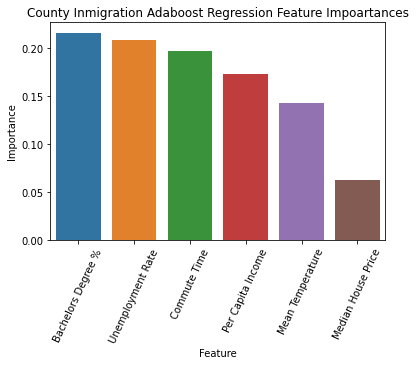

In [104]:
fig, ax = plt.subplots()
sns.barplot(x='Feature', y='Importance', data=adaboost_importances_df, ax=ax)
ax.set_title('County Inmigration Adaboost Regression Feature Impoartances')
ax.set_xticklabels(adaboost_importances_df['Feature'], rotation=65)